# <b>1. ResNet 50</b>

### Import Dataset

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="IaXBEeWUF7jj47qZcsVn")
project = rf.workspace("firstproject-qh0bd").project("plant-identification-41vnn")
version = project.version(1)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Plant-Identification-1 in folder:: 100%|██████████| 19216/19216 [00:06<00:00, 2838.37it/s]


### Import Library

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.image as mpimg

### Dataset Configuration

In [4]:
# Data directory paths
train_dir = '/content/Plant-Identification-1/train'
val_dir = '/content/Plant-Identification-1/valid'
test_dir = '/content/Plant-Identification-1/test'
img_size = 224
batch_size = 32


In [5]:
# ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
# Dataset generators
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 16145 images belonging to 22 classes.


In [7]:
val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2000 images belonging to 22 classes.


In [8]:
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1000 images belonging to 22 classes.


In [9]:
# Display class names
class_names = train_ds.class_indices
print("Class Names:", list(class_names.keys()))

Class Names: ['Adulsa', 'Alovera', 'Amla', 'Banana', 'BeetalLeaf(Pan)', 'Bramhi', 'CurryLeaves', 'Drumstick', 'Eranda', 'Gokarna', 'Hibiscus', 'Jamun(IndianBlackberry)', 'Mango', 'Neem', 'Onion', 'Panfuti', 'Papaya', 'Satynashi', 'Shatavari', 'Sugarcane', 'Tandulja', 'TouchMeNot']


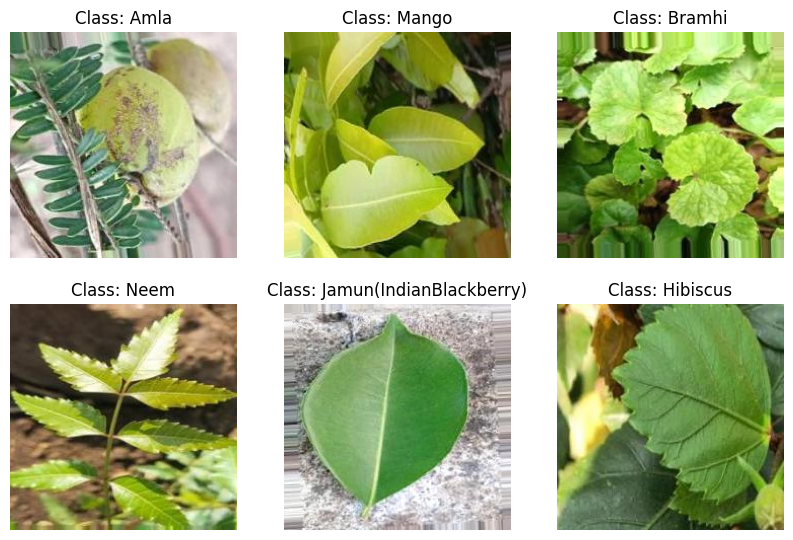

In [10]:
# Display sample images
plt.figure(figsize=(10, 10))
images, labels = next(train_ds)
for i in range(min(images.shape[0], 6)):
    ax = plt.subplot(3, 3, i + 1)
    image_to_display = images[i] * 255 if images[i].max() <= 1 else images[i]
    plt.imshow(image_to_display.astype("uint8"))
    predicted_class_index = np.argmax(labels[i])
    class_name = list(class_names.keys())[list(class_names.values()).index(predicted_class_index)]
    plt.title(f"Class: {class_name}")
    plt.axis("off")
plt.show()

### Model Defination

In [ ]:


# ResNet50 Model
def create_resnet50_model(input_shape=(224, 224, 3), num_classes=22):
    input_tensor = Input(shape=input_shape)

    # Load ResNet50 without top layers
    pretrained_model = tf.keras.applications.ResNet50(
        include_top=False,
        input_tensor=input_tensor,
        pooling='avg',
        weights='imagenet'
    )

    # Freeze the pre-trained layers
    for layer in pretrained_model.layers:
        layer.trainable = False

    # Add custom layers
    x = Flatten()(pretrained_model.output)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = Model(inputs=pretrained_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [12]:
# Create the model
num_classes = len(class_names)
resnet50_model = create_resnet50_model(num_classes=num_classes)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [13]:
resnet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,648,086 (94.02 MB)

 Trainable params: 1,060,374 (4.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Training the Model

In [14]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [15]:
# Train the model
epochs = 25
history = resnet50_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/25


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


505/505 ━━━━━━━━━━━━━━━━━━━━ 94s 160ms/step - accuracy: 0.0810 - loss: 3.0627 - val_accuracy: 0.1440 - val_loss: 2.9065
Epoch 2/25
505/505 ━━━━━━━━━━━━━━━━━━━━ 69s 136ms/step - accuracy: 0.1400 - loss: 2.8662 - val_accuracy: 0.1485 - val_loss: 2.7921
Epoch 3/25
505/505 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - accuracy: 0.1796 - loss: 2.7708 - val_accuracy: 0.1955 - val_loss: 2.6998
Epoch 4/25
505/505 ━━━━━━━━━━━━━━━━━━━━ 70s 137ms/step - accuracy: 0.2069 - loss: 2.6808 - val_accuracy: 0.2315 - val_loss: 2.5825
Epoch 5/25
505/505 ━━━━━━━━━━━━━━━━━━━━ 82s 138ms/step - accuracy: 0.2181 - loss: 2.6275 - val_accuracy: 0.2230 - val_loss: 2.5678
Epoch 6/25
505/505 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - accuracy: 0.2373 - loss: 2.5593 - val_accuracy: 0.2495 - val_loss: 2.5148
Epoch 7/25
505/505 ━━━━━━━━━━━━━━━━━━━━ 70s 138ms/step - accuracy: 0.2494 - loss: 2.5295 - val_accuracy: 0.2495 - val_loss: 2.5029
Epoch 8/25
505/505 ━━━━━━━━━━━━━━━━━━━━ 80s 133ms/step - accuracy: 0.2581 - loss: 2.4938 - val

In [16]:
# Evaluate the model
print("Evaluating model...")
val_loss, val_accuracy = resnet50_model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.3771 - loss: 2.0759
Validation Accuracy: 36.50%


### Prediction

In [20]:
# Save class indices as JSON
import json
class_indices = {v: k for k, v in train_ds.class_indices.items()}
json.dump(class_indices, open('class_indices.json', 'w'))


In [17]:
# Predict a single image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array


In [18]:
def predict_image_class_with_probabilities(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_probabilities = {class_name: round(prob * 100, 2) for class_name, prob in zip(class_indices.values(), predictions[0])}
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    predicted_class_prob = class_probabilities[predicted_class_name]
    return predicted_class_name, predicted_class_prob, class_probabilities


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


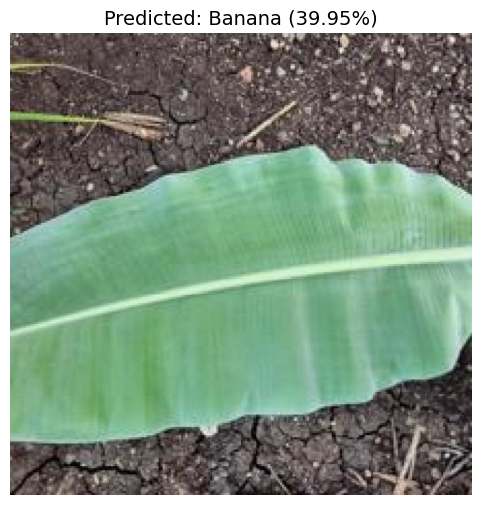

In [22]:
image_path = '/content/Plant-Identification-1/test/Banana/20241105_145615_jpg.rf.9c1f9761dbcdce475667d48e33f24591.jpg'
predicted_class_name, predicted_class_prob, class_probabilities = predict_image_class_with_probabilities(resnet50_model, image_path, class_indices)

# Display results
img = mpimg.imread(image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class_name} ({predicted_class_prob}%)", fontsize=14)
plt.show()

### Class Probability

In [23]:
print("Class Probabilities:")
for class_name, prob in sorted(class_probabilities.items()):
    print(f"{class_name}: {prob:.2f}%")

print("\nPredicted Class:", predicted_class_name)
print(f"Probability of Predicted Class: {predicted_class_prob:.2f}%")

Class Probabilities:
Adulsa: 0.35%
Alovera: 4.92%
Amla: 0.78%
Banana: 39.95%
BeetalLeaf(Pan): 0.11%
Bramhi: 0.03%
CurryLeaves: 0.47%
Drumstick: 0.14%
Eranda: 0.20%
Gokarna: 0.22%
Hibiscus: 0.93%
Jamun(IndianBlackberry): 29.13%
Mango: 3.88%
Neem: 0.23%
Onion: 6.80%
Panfuti: 1.59%
Papaya: 0.24%
Satynashi: 0.01%
Shatavari: 0.01%
Sugarcane: 9.98%
Tandulja: 0.01%
TouchMeNot: 0.05%

Predicted Class: Banana
Probability of Predicted Class: 39.95%


### Graph Plot 

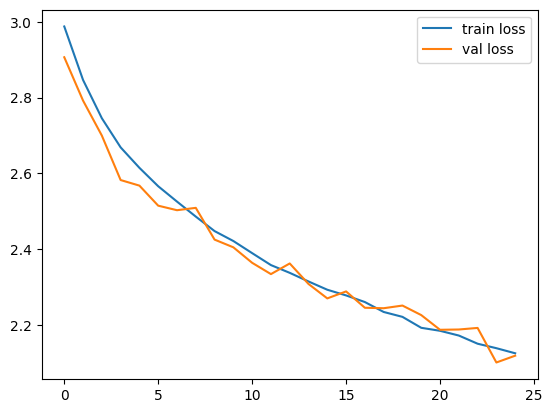

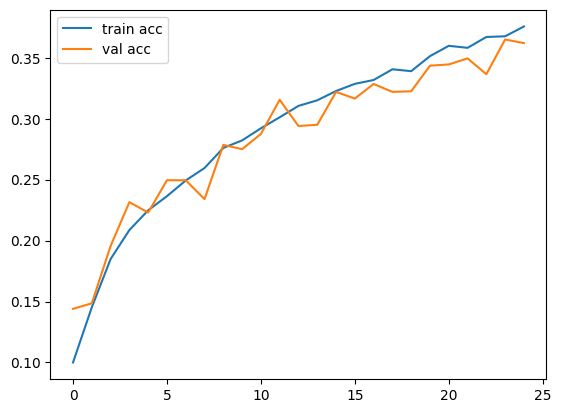

In [24]:
# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

### Save Model

In [25]:
# Save the model in HDF5 format
model_save_path = 'resnet50_plant_identification_model.h5'
resnet50_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Download the saved model
from google.colab import files
files.download(model_save_path)


Model saved to resnet50_plant_identification_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Save the model weights to an HDF5 file with the correct extension
resnet50_model.save_weights('resnet50_plant_identification_weights.weights.h5')

# Download the weights file
from google.colab import files
files.download('resnet50_plant_identification_weights.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>